# Determining ice sheet change using Greenland Ice Mapping Project (GrIMP) tools
---

![GrIMP header](./images/GrIMP_header.png)

## GrIMP Products

After more than 15 years, there is large volume (>2TB) of Greenland DEMs, velocity maps, and SAR mosaics at NSIDC.

![GrIMP Products](./images/Products.jpg)

## GrIMP Overview and Tutorial Goals

```{note} Learning Objectives
	
1. Access GrIMP velocity products, formatted as cloud optimized GeoTIFF
2. Explore product header info and structure
3. Use interactive subsetting and save tools
4. Demonstrate lazy opens open large data sets without actually downloading
5. Combine raster and vector data to quickly assess glacier speed and terminus change 
6. Generate plots of time series for points on a glacier
```

This notebook illustrates some of the various tools and capabilities available to access and explore imagery and velocity data products from the Greenland Ice Mapping Project [GrIMP](https://nsidc.org/grimp). 

Specifically, we will use the functionality of the `nisarVelSeries` classes for working with GrIMP velocity products.

This notebook will also include examples of how to quickly explore imagery and velocity mosaics, formatted as cloud optimized GeoTIFF (more on that below) to interactively select and download subsets of GrIMP imagery (NSIDC-0723) and velocity (NSIDC-481, 0725, 0727, 0731, 0766) data. For the Sentinel-based velocity mosaics (0725, 0727, 0731), a user can select a box on a map and choose which components are downloaded (vv, vx, vy, ex, ey, dT) and saved to a netCDF file. 

**All GrIMP notebooks and associated code can reached from the [**GrIMP overview repository**](https://github.com/fastice/GrIMPTools)**

**Tools that allow users to extract time series for their regions of interest in manageable size volumes are essential.**

## Key Features
Several features of these classes are useful for working with the GrIMP data as described below.

### Cloud Optimized Geotiffs
Much of the functionality described here relies on the use of Cloud-optimized Geotiffs ([COGs](https://developers.planet.com/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/)) for GriMP products, which have the following properties:
    
- The header with information about how the data are organized is all located at the beginning of the file. As a result, a result a single read provides all of the information about how the data are organized in the file. In some tiffs this information is distributed throughout the file, requiring many read operations to retrieve all of the metadata.
- The data are tiled (i.e., stored as a series of blocks like a checkerboard) rather than as a line-by-line raster. The tiling facilitates faster access to limited subsets. For example, to read a 50-by-50 km region from a Greeland mosaic, only a few tiles that cover that region need to be downloaded. By contrast, with conventional rastering, a 50km-by-1500km (~width of Greenland mosaics) would have to read (up to 30x more data) and then cropped to the desired width of 50km. 
- A consistent set of overview images (pyramids) are stored with the data, allowing low-resolution images to be quickly extracted to create figures where the full resolution is not required (e.g., for inset figures).


### Built on Xarray
[*Xarray*](https://docs.xarray.dev/en/stable/) is a powerful python tool that bundles metadata with data stored in NumPy arrays. While extremely powerful, it can be cumbersome for novice users. The classes described below are designed so that users can take advantage of the full functionality of Xarray, or bypass it entirely and access the data using either as [numpy](https://numpy.org) arrays or methods that perform tasks commonly applied to the data (interpolation, basic statistics, etc).

### Dask
[Dask](https://dask.org) is a program for applying parallel operations using Xarray, NumPy, and other libraries.  Dask functionality is included implicitly in these libraries as well as the classes described below. It builds on the lazy-open capabilities in that it can operate on the metadata and cue up several complex operations before actual data download, providing the advantages of parallelism in a way that is transparent to the user.

### Local and Remote Subsetting
After one of the classes described below performs a lazy open (e.g., a Greenland-wide map),  often the next task is to apply a subsetting (cropping) operation to limit access to only the region of interest. All subsetting operations are non-destructive with respect to the full data set, so multiple subsetting operations can be applied in series. 

After a subset is created, it initially retains its lazy-open status, which in many cases is a convenient way to work. For many operations, the data will automatically be downloaded as needed (e.g., for a plot). But if the data are used multiple times, it is better to explicitly download the data to avoid multiple downloads of the same data, which can greatly slow operations. In some cases, the system cache will retain the data and void repeat downloading, but large datasets can cause the cache to quickly be flushed and trigger redundant downloads. If there is sufficient memory, multiple downloads can be avoided by explicitly downloading the data to local memory as described below.

### Subsets Can Be Saved For Later Use

Subsets can be written to netCDF files and re-read for later use.

## Environment setup

Generally, GrIMP notebooks use a set of tools that have been tested with the `environment.yml` in the *binder* folder of the [**GrIMP repository**](https://github.com/fastice/GrIMPTools). Thus, for best results when using GrIMP notebooks in the future and in local instances, create a new conda environment to run this and other other GrIMP notebooks from this repository. After downloading the `environment.yml` file, enter the following commands at the command line to prepare your environment. For today's tutorial in CryoCloud, we do not need to perform these steps.

`conda env create -f binder/environment.yml`

`conda activate greenlandMapping`

`python -m ipykernel install --user --name=greenlandMapping`

`jupyter lab`

See [NSIDCLoginNotebook](https://github.com/fastice/GrIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for additional information.

The notebooks can be run on a temporary virtual instance (to start click [**binder**](https://mybinder.org/v2/gh/fastice/GrIMPNotebooks/HEAD?urlpath=lab)). See the github [README](https://github.com/fastice/GrIMPNotebooks#readme) for further details.

### Specialty GrIMP product imports

```{note}
In order to use the full functionality of GrIMP notebooks for this tutorial, we will pip install two
two packages with funcitons for reading, subsetting, plotting, and downloading various datasets.
```

### GrIMP imports

In [1]:
try:
    import grimpfunc as grimp
except Exception:
    %pip install -q git+https://github.com/fastice/grimpfunc.git@master
    import grimpfunc as grimp
#
try:
    import nisardev as nisar
except Exception:
    %pip install -q git+https://github.com/fastice/nisardev.git@main
    import nisardev as nisar

### Common package imports

In [2]:
# Ignore warnings for tutorial
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Image
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)
import panel
panel.extension()
from datetime import date, datetime
from shapely.geometry import box, Polygon
%load_ext autoreload
%autoreload 2

## Earth Data Login (Optional for This Tutorial)

These environment variabiles are needed to make the remote access work. The cookie file will be created with login procedure in the following step.

In [3]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.grimp_download_cookiejar.txt')) # Modify path as needed
os.environ.update(env)

If this is a first login, you will be prompted for your earthdata user name and passwd. A netrc file will be created or updated so the information does not need to be retyped on subsequent login attempts.

In [4]:
myLogin = grimp.NASALogin()
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.




### &#x1F4CC; More tutorial guidance:
See our [YouTube](https://www.youtube.com/@GreenlandIceMappingProject) page for more:

In [5]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/0kIcSXkxaxI" \
     frameborder="0" allow="accelerometer" allowfullscreen></iframe>')

```{note}
**To get help and see options for any of the GrIMP or other functions while the cursor is \
positioned inside a method's parentheses, click shift+Tab.**
```

## Overview of COGs and GrIMP product exploratory tool

GrIMP velocity products are stored at NSIDC in cloud-optimized GeoTIFF (COG) format with each component stored as a separate band (e.g., vx, vy, or vv). In this notebook, we focus on the velocity data, but the error and x and y displacement components can be similarly processed.

For reading the data, the products are specified with a single root file name (e.g., for `filename.vx(vy).version.tif`). For example, the version 3 annual mosaic from December 2017 to November 2018 is specified as `GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v03.0`. For locally stored files, the corresponding path to the data must be provided. For remote data, the https link is required.  In the following example, the `initialSearch()` function populates a gui search window, which allows the search parameters to be altered.

Note, you *may* need to run this cell block twice to initially see the list and total file number repopulate to your selections.

In [6]:
# mode='nisar' for full Greenland mosaics
# mode='subsetter' for all raster products
# mode='image' for just image products
# mode='none' for all products
myUrls = grimp.cmrUrls(mode='nisar')  
display(myUrls.initialSearch())

Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method, _pane=DataFrame)
        [1] ParamMethod(method, _pane=Markdown)
        [2] ParamMethod(method, _pane=Markdown)

This cell will pop up a search tool for the GrIMP products, which will run a predefined search for the annual products. While in principle, other products (e.g., six-day to quarterly can be retrieved, the rest of the notebook will need some modifications to accomodate).

The results from the search can be returned with the following method call:

In [7]:
myUrls.getCogs(replace='vv', removeTiff=True)

['https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2014.12.01/GL_vel_mosaic_Annual_01Dec14_30Nov15_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2015.12.01/GL_vel_mosaic_Annual_01Dec15_30Nov16_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2016.12.01/GL_vel_mosaic_Annual_01Dec16_30Nov17_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2017.12.01/GL_vel_mosaic_Annual_01Dec17_30Nov18_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2018.12.01/GL_vel_mosaic_Annual_01Dec18_30Nov19_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2019.12.01/GL_vel_mosaic_Annual_01Dec19_30Nov20_*_v04.0',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.004/2020.12.01/GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v04.0']

The search returned values for the speed products, which are indicated by a 'vv' in the name. In the above call, the 'vv' is replaced with a wildcard, '\*', using the `replace='vv'` keyword. The subsequent programs will also automatically append the tif, so the `removeTiff=True` is used to remove the '.tif' extension.

### Preload Data and Select Bands
The cells in this section read the cloud-optimized geotiffs (COG) headers and create nisarVelSeries or nisarImageSeries objects for velocity or image data, respectively. The bands (e.g., vx, vy) can be selected at this stage.

More detail can found on working with these tools in the workingWithGrIMPVelocityData and workingWithGrIMPImageData notebooks. 

```{note}
The  nisar class is used to read, display, velocity maps with a single time stamp. In this example, the `readSpeed=False` (default) forces the speed to be calculated from the individual components rather than read from a file, which is much quicker. The `url=True` keyword indicates the data are being pulled from http links.

: Here is an example of how to access header information remotely and see the structure and total size of your potential download

:     myVelSeries = nisar.nisarVelSeries() 
      myVelSeries.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False, useErrors=True, useDT=False)  
      myVelSeries.xr
```

### View example mosaic product from local file
For the purpose of this tutorial, we will read in a file saved locally to the shared directory to visualize an example of the annual velocity mosaic. For local file acccess, we set `url=False`, otherwise everything else is the same as for remote access. The data are stored at several resolutions, which can be specified by the `overviewLevel` keyword. Full resolution is `overviewLevel=-1`. To plot a full map of Greenland this resolution would slow things down, so we can pick a lower resolution with values of 0, 1, 2..., with each increment halving the resolution. The cell block below uses a function in the `nisar` package to initialize a nisarVelSeries instance:

In [8]:
myVelSeries = nisar.nisarVelSeries() 
# Path to local file
localFile = '/home/jovyan/shared-public/GeoTIFF/GL_vel_mosaic_Annual_01Dec20_30Nov21_*_v04.0'
# This builds a series, which is specified by a list of files. So with 1 file, the brackets are used to pass a list rather than a single file name
myVelSeries.readSeriesFromTiff([localFile], useDT=False, useErrors=False, readSpeed=True, url=False, useStack=True, overviewLevel=1)  
myVelSeries.xr

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 3425, x: 1896)>
dask.array<concatenate, shape=(1, 3, 3425, 1896), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.587e+05 -6.579e+05 ... 8.567e+05 8.575e+05
  * y            (y) float64 -6.395e+05 -6.403e+05 ... -3.378e+06 -3.379e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2021-06-01
  * band         (band) <U2 'vx' 'vy' 'vv'
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30

The actual data are not downloaded at this stage, but the xarray internal to each object will read the header data of each product so it can efficiently access the data during later downloads.

### Plot velocity map

This will plot the velocity map for the annual mosaic nearest the user-provided date (in this example there is only one date, so the date could be omitted). Below, we will use mid 2021. Note, since this series has only one year, the date could have been omitted.

[########################################] | 100% Completed | 411.48 ms
[########################################] | 100% Completed | 101.48 ms


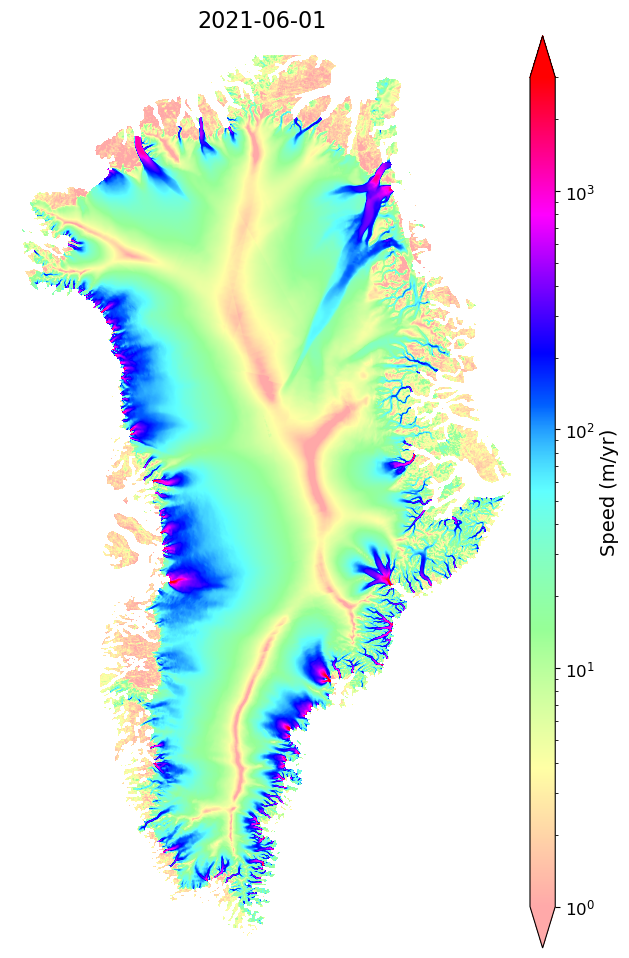

In [9]:
myVelSeries.displayVelForDate('2021-06-01',labelFontSize=14, plotFontSize=12, titleFontSize=16, 
                              vmin=1, vmax=3000, scale='log',colorBarPad=0.15, units='km', axisOff=True)

## Remote Example for 2020 velocity map (optional)

[########################################] | 100% Completed | 3.46 sms
[########################################] | 100% Completed | 202.99 ms


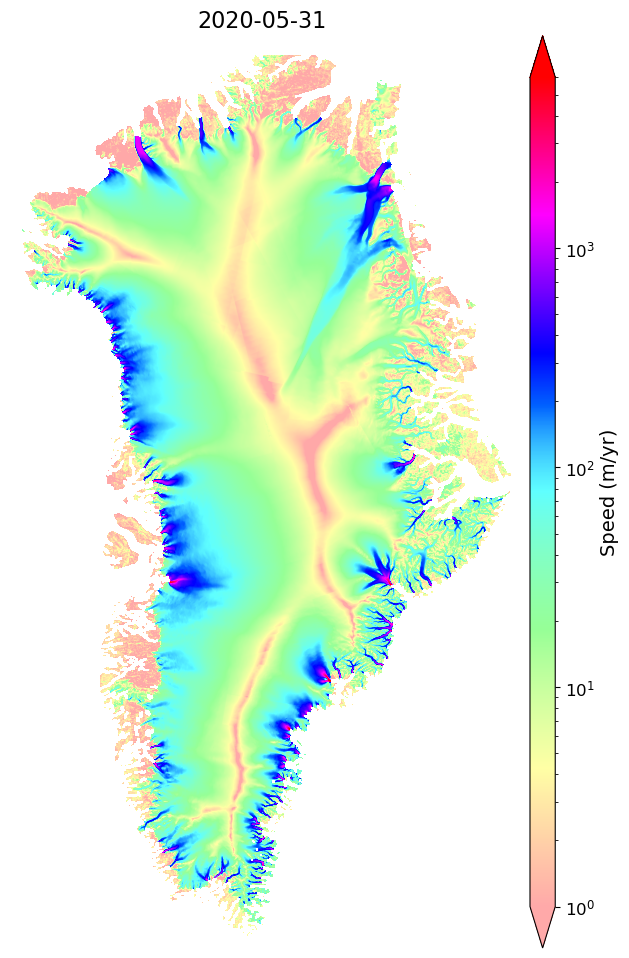

In [10]:
myVelSeriesRemote = nisar.nisarVelSeries() 
myVelSeriesRemote.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False, useErrors=False, useDT=False, overviewLevel=1) 
myVelSeriesRemote.displayVelForDate('2020-06-01',labelFontSize=14, plotFontSize=12, titleFontSize=16, 
                              vmin=1, vmax=6000,scale='log',colorBarPad=0.15,units='km', axisOff=True)

In [11]:
myVelSeriesRemote.subset

<xarray.DataArray 'VelocityMap' (time: 7, band: 3, y: 3425, x: 1896)>
dask.array<concatenate, shape=(7, 3, 3425, 1896), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -6.587e+05 -6.579e+05 ... 8.567e+05 8.575e+05
  * y            (y) float64 -6.395e+05 -6.403e+05 ... -3.378e+06 -3.379e+06
  * time         (time) datetime64[ns] 2015-06-01 ... 2021-06-01
  * band         (band) <U2 'vx' 'vy' 'vv'
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2020-12-01
    time2        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2021-11-30
    spatial_ref  int64 0

## &#128208; Spatial subsetting routines 
&#x1F6A8;**These files can be large!**

Below are functions that allow you to quickly *subset the data by spatial bounds*, including the functions you can use to interactively select an ROI when exploring datasets remotely

### Method 1: Interactive ROI Selection
Run the next the tool below to select the bounding box (or modify a manually selected box), which will display a SAR image map. Depending on network speed, it could take a few seconds to a minute to load the basemap. Use the box tool in the plot menu to select a region of interest. 

```{admonition} Interactive ROI selection
: To pick the box interactively
:     boxPicker = grimp.boxPicker()
      boxPicker.plotMap()
: In a subsequent cell to return the bounds of the picked box
:     boxPicker.boxBounds(decimals=-3)
```

### Method 2: Manual Selection
The coordinates for a bounding box can be manually entered by modifying the cell below with the desired values. Even if not using interactive selection, running that step displays the manually selected box coordinates on a radar map of Greenland. Note by default, coordinates are rounded to the nearest kilometer. We will use numpy to define a specific x and y bounds of our ROI for the tutorial today.

In [12]:
values = np.around([-243889, -2295095, -149487, -2255127], decimals=-3)
xyBounds = dict(zip(['minx', 'miny', 'maxx', 'maxy'], values))
xyBounds

{'minx': -244000, 'miny': -2295000, 'maxx': -149000, 'maxy': -2255000}

With this bounding box, we can subset the data to pull out the area of interest.

In [13]:
myVelSeries.subSetVel(xyBounds)
myVelSeries.subset

<xarray.DataArray 'VelocitySeries' (time: 1, band: 3, y: 51, x: 120)>
dask.array<getitem, shape=(1, 3, 51, 120), dtype=float32, chunksize=(1, 1, 29, 120), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 -2.442e+05 -2.434e+05 ... -1.498e+05 -1.49e+05
  * y            (y) float64 -2.255e+06 -2.256e+06 ... -2.294e+06 -2.295e+06
  * time         (time) datetime64[ns] 2021-06-01
  * band         (band) <U2 'vx' 'vy' 'vv'
    name         <U4 'None'
    _FillValue   (band) float64 -2e+09 -2e+09 -1.0
    time1        datetime64[ns] 2020-12-01
    time2        datetime64[ns] 2021-11-30
    spatial_ref  int64 0

The data in the above example map are stored as an Xarray, velMap.subset, here representing data clipped spatially by `xyBounds`. The full time series of Greenland-wide mosiacs can reach sizes of > 8GB and may take awhile to download! Because of the lazy open mentioned above, the data have not been downloaded or read from the disk yet. Before applying the final subset, its useful to examine the size of the full data (virtual) array. If the loadDataArray step was sucessful, running the cell above will provide details on the size and organization of the full xarray (prior to any download).

We can now view this image with `displayVelForDate` method.

[########################################] | 100% Completed | 101.49 ms
[########################################] | 100% Completed | 101.36 ms
[########################################] | 100% Completed | 101.56 ms
[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 101.22 ms


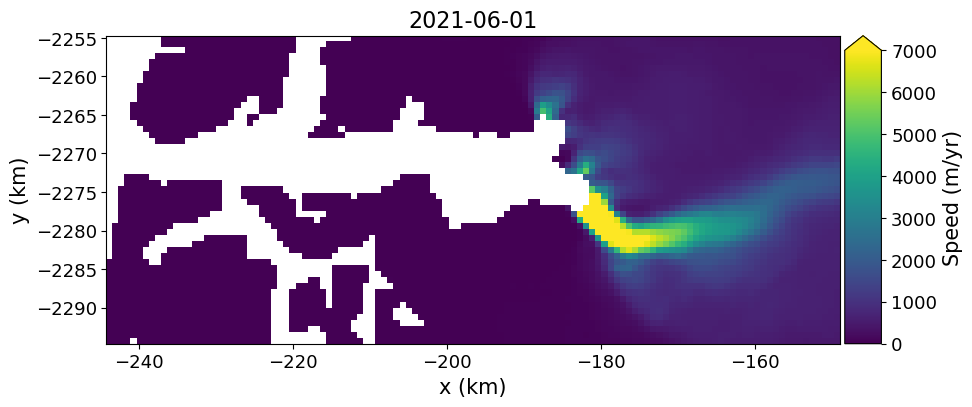

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
myVelSeries.displayVelForDate('2021-06-01', units='km', ax=ax)  # Note the x, y units can either be 'm' or 'km'

## Remote Access and Downloading to Local Memory

In [15]:
myVelSeriesFullRes = nisar.nisarVelSeries() 
myVelSeriesFullRes.readSeriesFromTiff(myUrls.getCogs(replace='vv', removeTiff=True), url=True, readSpeed=False, useErrors=False, useDT=False, overviewLevel=-1) # This is now -1 to download full res data
#
myVelSeriesFullRes.xr

<xarray.DataArray 'VelocitySeries' (time: 7, band: 3, y: 13700, x: 7585)>
dask.array<concatenate, shape=(7, 3, 13700, 7585), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2015-06-01 ... 2021-06-01
    id              (time) <U114 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES...
  * band            (band) <U2 'vx' 'vy' 'vv'
  * x               (x) float64 -6.59e+05 -6.588e+05 ... 8.576e+05 8.578e+05
  * y               (y) float64 -6.392e+05 -6.394e+05 ... -3.379e+06 -3.379e+06
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-659100.0, -...
    ...              ...
    epsg            int64 3413
    name            <U4 'temp'
    spatial_ref     int64 0
    time1           (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2020-12-01
    time2           (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2021-11-30
    _FillValue      float64 -1.0

In [16]:
myVelSeriesFullRes.subSetVel(xyBounds)
myVelSeriesFullRes.subset

<xarray.DataArray 'VelocitySeries' (time: 7, band: 3, y: 201, x: 476)>
dask.array<getitem, shape=(7, 3, 201, 476), dtype=float32, chunksize=(1, 1, 113, 476), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2015-06-01 ... 2021-06-01
    id              (time) <U114 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES...
  * band            (band) <U2 'vx' 'vy' 'vv'
  * x               (x) float64 -2.44e+05 -2.438e+05 ... -1.492e+05 -1.49e+05
  * y               (y) float64 -2.255e+06 -2.255e+06 ... -2.295e+06 -2.295e+06
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-659100.0, -...
    ...              ...
    epsg            int64 3413
    name            <U4 'temp'
    time1           (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2020-12-01
    time2           (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2021-11-30
    _FillValue      float64 -1.0
    spatial_ref     int64 0

Now Download the data to local memory.

In [17]:
myVelSeriesFullRes.loadRemote()
myVelSeriesFullRes.subset

[########################################] | 100% Completed | 2.43 sms


<xarray.DataArray 'VelocitySeries' (time: 7, band: 3, y: 201, x: 476)>
array([[[[           nan,            nan,            nan, ...,
          -2.6192258e+02, -2.6110687e+02, -2.5963602e+02],
         [           nan,            nan,            nan, ...,
          -2.6243689e+02, -2.6265280e+02, -2.6182913e+02],
         [           nan,            nan,            nan, ...,
          -2.6341708e+02, -2.6438687e+02, -2.6455112e+02],
         ...,
         [ 5.5365521e-01,  6.8432176e-01, -1.9879930e-01, ...,
          -4.9561163e+02, -4.9355795e+02, -4.9148721e+02],
         [ 5.7494551e-01,  5.6204200e-01,  1.7035259e-01, ...,
          -4.8163956e+02, -4.7927661e+02, -4.7711523e+02],
         [ 8.1131196e-01,  6.8624878e-01,  4.0664664e-01, ...,
          -4.6736694e+02, -4.6446072e+02, -4.6205780e+02]],

        [[           nan,            nan,            nan, ...,
          -2.1215604e+02, -2.0939720e+02, -2.0615363e+02],
         [           nan,            nan,            nan, ...,
          -2.1113820e+02, -2.0640562e+02, -2.0608829e+02],
         [           nan,            nan,            nan, ...,
          -2.0880780e+02, -2.0407518e+02, -2.0374881e+02],
...
           1.8178641e+02,  1.7426544e+02,  1.6836679e+02],
         [-2.1904887e-01, -7.4980244e-02, -3.2354692e-01, ...,
           1.7628020e+02,  1.6905730e+02,  1.6450157e+02],
         [-4.2203876e-01, -5.6404436e-01, -6.0951587e-02, ...,
           1.6945511e+02,  1.6406068e+02,  1.5986591e+02]],

        [[           nan,            nan,            nan, ...,
           3.0223358e+02,  3.0174768e+02,  3.0306824e+02],
         [           nan,            nan,            nan, ...,
           3.0335999e+02,  3.0227481e+02,  3.0381125e+02],
         [           nan,            nan,            nan, ...,
           3.0539755e+02,  3.0332596e+02,  3.0395535e+02],
         ...,
         [ 7.2725827e-01,  9.6467805e-01,  3.0525929e-01, ...,
           4.8734317e+02,  4.8255627e+02,  4.7840131e+02],
         [ 2.6955080e-01,  4.5673341e-01,  4.4953457e-01, ...,
           4.7171356e+02,  4.6680215e+02,  4.6298315e+02],
         [ 4.6289936e-01,  7.6540822e-01,  4.7070682e-01, ...,
           4.5596146e+02,  4.5183676e+02,  4.4825406e+02]]]],
      dtype=float32)
Coordinates: (12/18)
  * time            (time) datetime64[ns] 2015-06-01 ... 2021-06-01
    id              (time) <U114 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES...
  * band            (band) <U2 'vx' 'vy' 'vv'
  * x               (x) float64 -2.44e+05 -2.438e+05 ... -1.492e+05 -1.49e+05
  * y               (y) float64 -2.255e+06 -2.255e+06 ... -2.295e+06 -2.295e+06
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-659100.0, -...
    ...              ...
    epsg            int64 3413
    name            <U4 'temp'
    time1           (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2020-12-01
    time2           (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2021-11-30
    _FillValue      float64 -1.0
    spatial_ref     int64 0

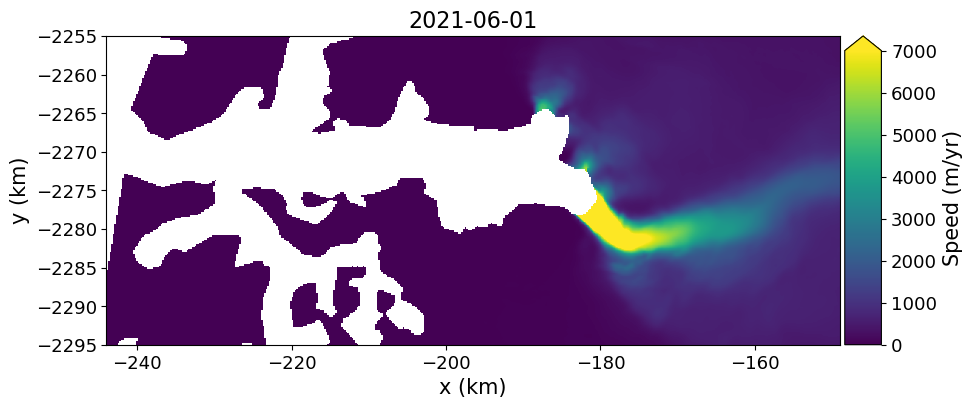

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
myVelSeriesFullRes.displayVelForDate('2021-06-01', units='km', ax=ax)

## Saving to NetCDF

```{admonition} Optionally download subset as netcdf file
The downloaded subset can be saved in a netcdf and reloaded for to velSeries instance for later   analysis.   Note if the data have been subsetted, ONLY the subset will be saved - so it is not a bad idea to check out the dimensions, variable names, and total size of the subset data one last time prior to downloading.

: Apply spatial subset and evaluate subsetted data size and structure          
:     myVelSeries.subSetVel(xyBounds)
      myVelSeries.subset

: To save your subset as a netcdf, follow the examples below:
:     subsetFile = 'steenstrupGlacier_annVel.nc'
      myVelSeries.loadRemote()
      myVelSeries.toNetCDF(subsetFile)
      
```


```{admonition} Review
**GrIMP data sets can be large. With these tools we can:**
- Preview large remote data sets to examine their layout,
- Subset to download only our region of interest,
- Download at the resolution most appropriate for the application,
- Apply these tools to either data on local disks or remote http links, 
- These tools can be used either on cloud-based system such CryoCloud or on your own laptop with little difference in performance,
- Save the downloaded results for later analysis.
      
```


## Displaying and Plotting Data

The remainder of the tutorial focuses on creating publication ready plots.

### Use predownloaded subset for plotting
Now, let's initialize another nisarVelSeries instance, and reload the previously downloaded data file 
(saved as netcdf) to that instance. &#x2B07;

In [19]:
myVelReload = nisar.nisarVelSeries() 
myVelReload.readSeriesFromNetCDF('./res/steenstrupGlacier_annVel.nc')
myVelReload.loadRemote()
myVelReload.xr #confirm dimensions of read-in subsetted velocities

<xarray.DataArray 'VelocitySeries' (time: 7, band: 3, y: 351, x: 306)>
array([[[[ 1.11676419e+00,  1.59998286e+00,  1.70799983e+00, ...,
           2.30640930e+02,  1.47605362e+02,  6.85445480e+01],
         [ 6.27350628e-01,  1.19134200e+00,  1.44590247e+00, ...,
           2.89960114e+02,  2.18558105e+02,  1.22185051e+02],
         [-1.73795328e-01,  1.81840569e-01,  1.62274435e-01, ...,
           3.05869354e+02,  2.55354233e+02,  1.62863892e+02],
         ...,
         [-4.73510027e+00, -5.52709627e+00, -5.25623894e+00, ...,
                      nan,             nan,             nan],
         [-2.86730933e+00, -3.33576107e+00, -3.83880162e+00, ...,
                      nan,             nan,             nan],
         [-1.34066474e+00, -1.90317583e+00, -2.72140670e+00, ...,
                      nan,             nan,             nan]],

        [[-5.82537270e+00, -5.66549730e+00, -5.22123241e+00, ...,
          -1.92974136e+02, -1.38507278e+02, -8.94227600e+01],
         [-4.98156023e+00, -4.58929014e+00, -3.94673991e+00, ...,
          -2.78241943e+02, -2.42269043e+02, -1.87016388e+02],
         [-4.90611362e+00, -4.50508499e+00, -3.54733062e+00, ...,
          -3.45336029e+02, -3.39918884e+02, -2.98722015e+02],
...
                      nan,             nan,             nan],
         [ 2.78865981e+00,  3.08081293e+00,  4.41497707e+00, ...,
                      nan,             nan,             nan],
         [ 6.93372369e-01,  2.12009978e+00,  3.43272281e+00, ...,
                      nan,             nan,             nan]],

        [[ 1.84553146e+00,  1.68653011e+00,  1.81761539e+00, ...,
           3.44428375e+02,  2.52386292e+02,  1.46040314e+02],
         [ 2.93052220e+00,  2.40399122e+00,  1.62190270e+00, ...,
           4.64432281e+02,  3.87946686e+02,  2.72755463e+02],
         [ 3.41516590e+00,  3.03598475e+00,  2.22783017e+00, ...,
           5.79738403e+02,  5.25995850e+02,  4.15923523e+02],
         ...,
         [ 6.43459558e+00,  7.29936552e+00,  7.30895853e+00, ...,
                      nan,             nan,             nan],
         [ 3.84925318e+00,  4.81166029e+00,  5.59751654e+00, ...,
                      nan,             nan,             nan],
         [ 3.06430936e+00,  3.67955160e+00,  4.11497211e+00, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
    _FillValue   float64 -1.0
  * time         (time) datetime64[ns] 2015-06-01 ... 2021-06-01
    id           (time) object 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/N...
  * band         (band) object 'vx' 'vy' 'vv'
  * x            (x) float64 4.19e+05 4.192e+05 4.194e+05 ... 4.798e+05 4.8e+05
  * y            (y) float64 -2.486e+06 -2.486e+06 ... -2.556e+06 -2.556e+06
    epsg         int64 3413
    name         <U4 'temp'
    time1        (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2020-12-01
    time2        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2021-11-30
    spatial_ref  int64 0
Attributes:
    grid_mapping:  spatial_ref

This time the `loadRemote` function loaded the data into local memory. The formatting for xarray display is no a little cruder than the remote dask version. 

### &#128397; Plot the annual velocity maps for Steenstrup Glacier (the glacier within our example spatial subset). 

This example loops over the time variable and plots the data for each year.

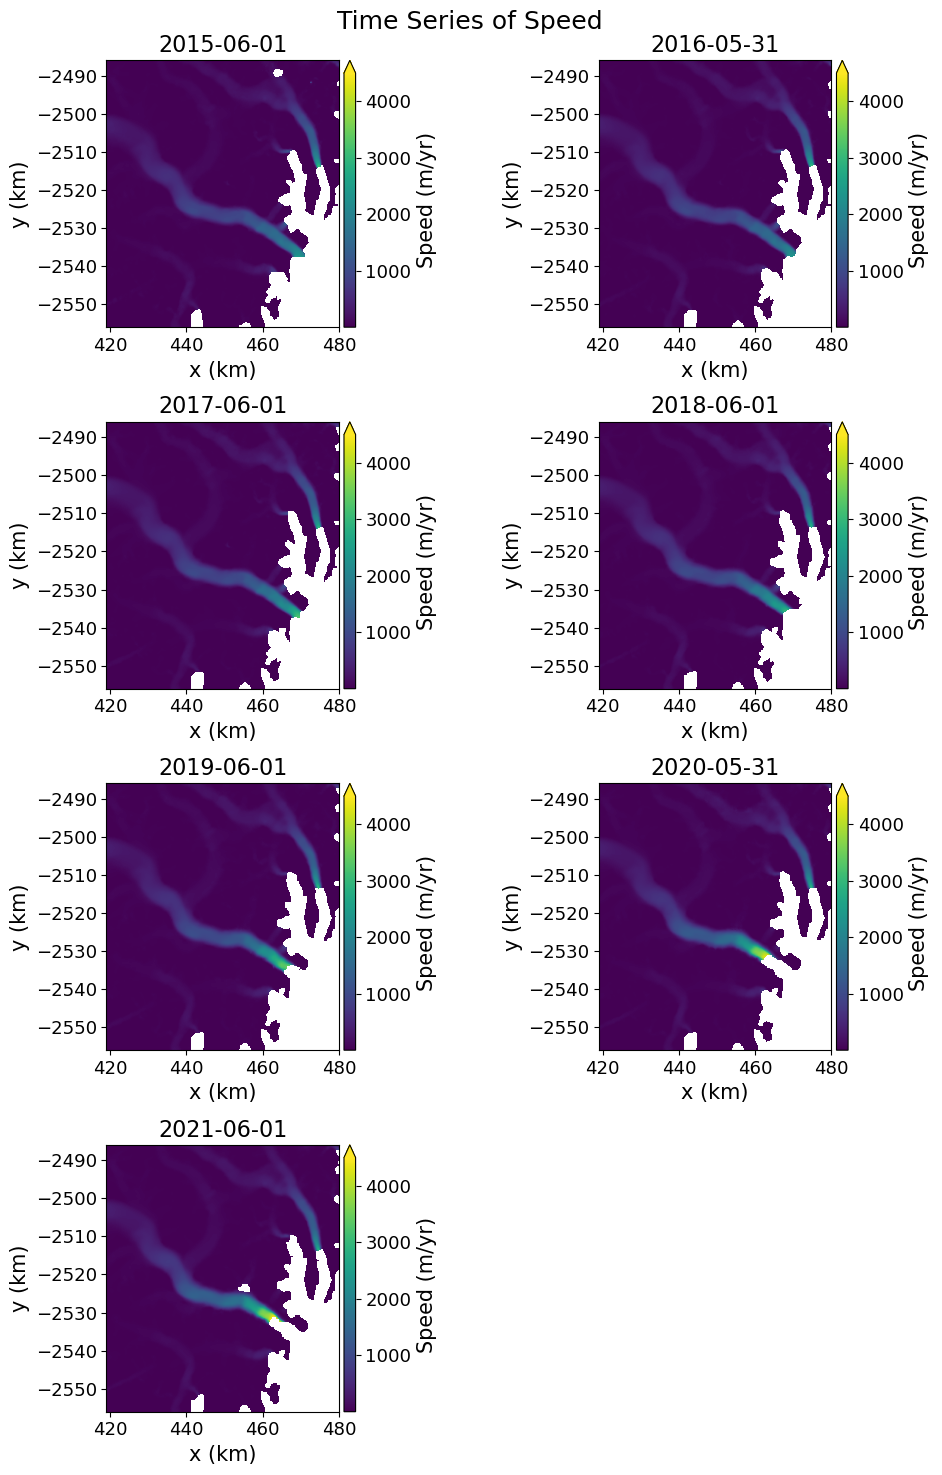

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(10,15))

for ax, date in zip(axes.flatten(), myVelReload.time): 
    myVelReload.displayVelForDate(date=date, ax=ax, autoScale=False,vmin=1, vmax=4500, units='km', axisOff=False, scale='linear')
axes[-1, -1].axis('off'); #remove any empty axes if odd number of years 
fig.suptitle('Time Series of Speed', fontsize=18)
fig.tight_layout()

### &#x1F4CA; Quickly plot velocity anomalies
There are functions to compute statistics such as mean and standard of the stack as well as the anomalies, which are the difference between the speed at each step and the mean for full series. The mean and anomalies are calculated as:

In [21]:
velAnomaly = myVelReload.anomaly() # These results are saved velSeries instances
velMean = myVelReload.mean()

These results can be plotted with these steps:

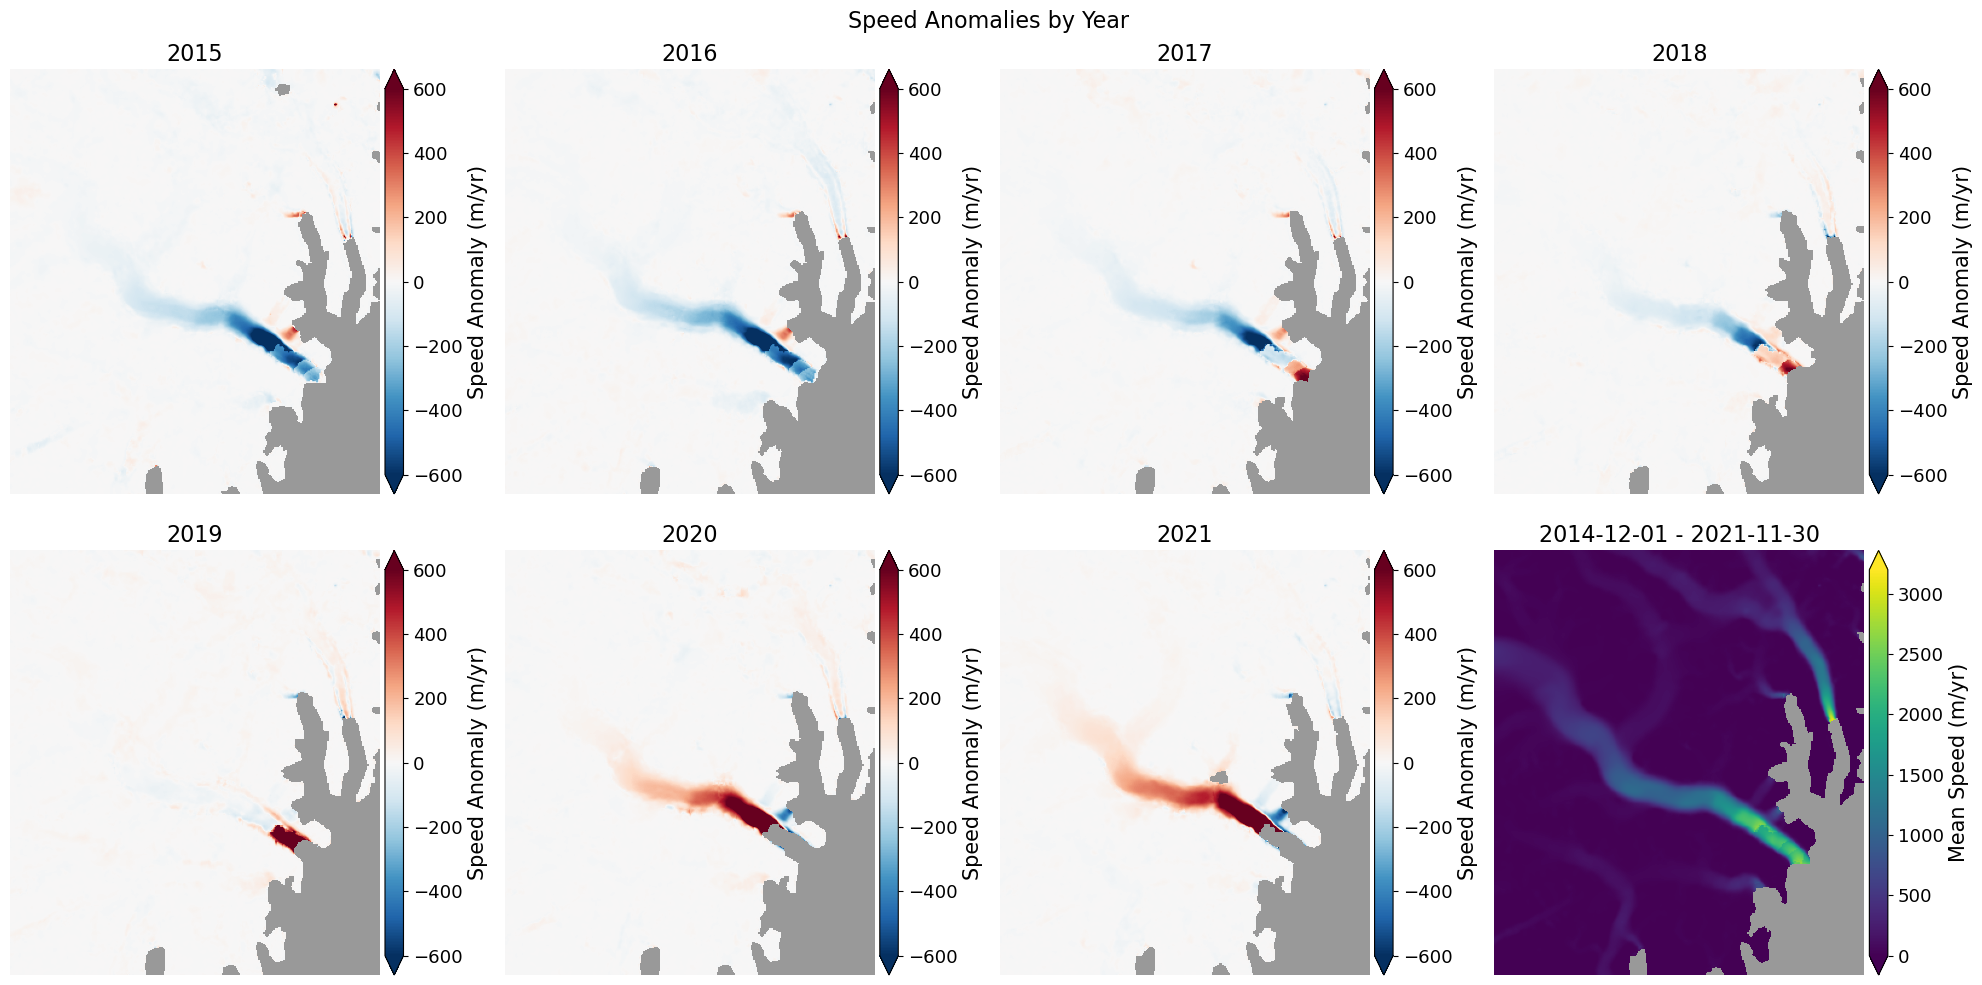

In [22]:
# Plot the anomaly for each year
fig, axes = plt.subplots(2, 4, figsize=(20,10))
# Loop over each anomaly
for date, ax in zip(velAnomaly.time, axes.flatten()):
    velAnomaly.displayVelForDate(date, ax=ax, units='m', vmin=-600, vmax=600, autoScale=False, axisOff=True,
                                 title=date.strftime("%Y"), cmap='RdBu_r', colorBarLabel='Speed Anomaly (m/yr)', 
                                 extend='both', backgroundColor=(0.6, 0.6, 0.6))
# Show the mean in the last panel
velMean.displayVelForDate(date, ax=axes[1,3], units='m', autoScale=True, axisOff=True,
                                 midDate=False, colorBarLabel='Mean Speed (m/yr)', 
                                 extend='both', backgroundColor=(0.6, 0.6, 0.6))
#
fig.suptitle('Speed Anomalies by Year', fontsize=16)
fig.tight_layout()

### &#x1F4C8; Explore multiyear trends with Quick tool
Use the interactive inspection tool in the cell block below to quickly visualize multiyear trends &#x2B07;

In [23]:
myVelReload.inspect()

HoloViews(Layout)

## &#128205; Combine GrIMP raster and vector data
Let's read in digitized annual glacier terminus traces within this ROI. The `compiled.shp` file is an aggregate of 2009-2021 annual terminus data from GrIMP product [**NSIDC-0642**](https://nsidc.org/data/nsidc-0642/versions/2). Run the cell block below to quickly view the Greenland-wide dataset.

<Axes: >

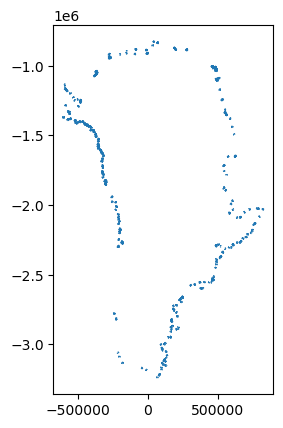

In [24]:
fronts = gpd.read_file("./shpfiles/compiled.shp")
fronts = fronts.to_crs("EPSG:3413")  # Convert to same crs as velocity data
fronts.plot()

Now we will use the bounds from the velSeries to create a box to filter out only the ice fronts in our region of interest.

<Axes: >

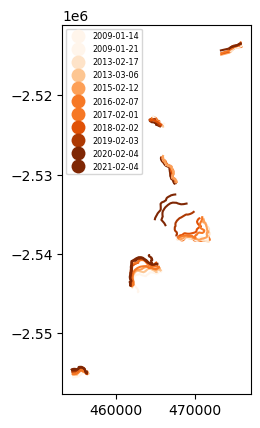

In [33]:
# define a polygone based on the xy extents of our reloaded velocity data
poly = box(*myVelReload.bounds())
clippedfronts = gpd.clip(fronts, poly)

Or = plt.colormaps['Oranges'].resampled(8)
clippedfronts.plot(column = "SourceDate",cmap=Or,legend=True,legend_kwds={'loc':'upper left','fontsize':'xx-small'})

Now we will plot the ice fronts over the velocity maps.

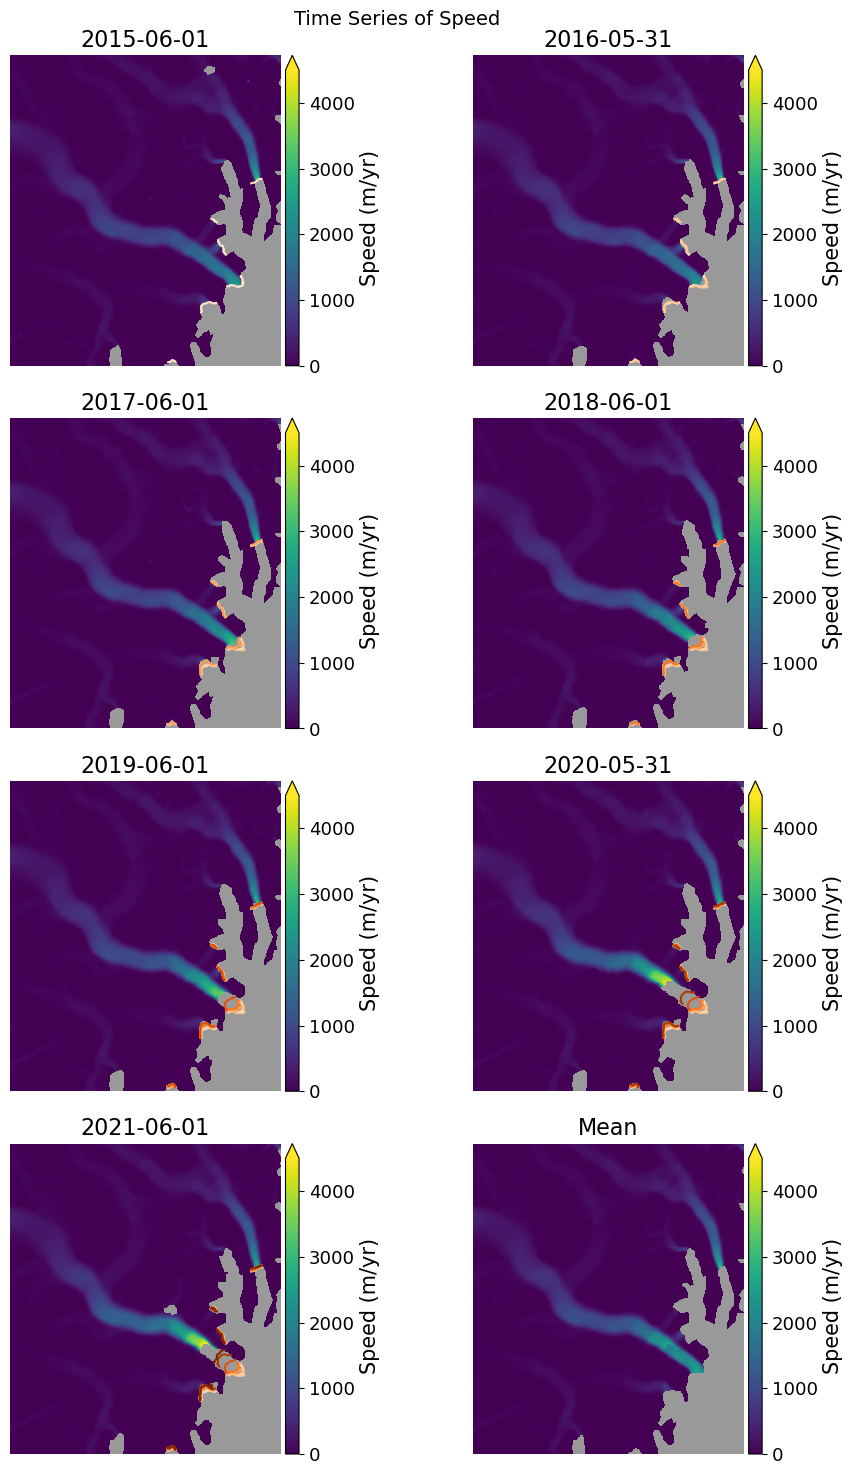

In [34]:
fig, axes = plt.subplots(4, 2, figsize=(10,15))

#define first year of time series
Yr1 = myVelReload.time[0].year

for ax, date in zip(axes.flatten(), myVelReload.time): 
    # vmax will limit the data to that value (the default is 7000 m/yr). But if autoscale is enabled
    # it will limit the output to the lesser of the maximum data value or vmax.
    # To force a specific range for all plots, specify vmin, vmax, and set autoscale to False.
    myVelReload.displayVelForDate(date=date, ax=ax, axisOff=True, autoScale=False, 
                                  vmin=0, vmax=4500, backgroundColor=(0.6,0.6,0.6))
    yr = date.year

    clipYr = clippedfronts.loc[pd.to_datetime(clippedfronts["SourceDate"]).dt.year <= yr]
    
    #sort shapefile features by date
    SortedTerm = clipYr.sort_values(by='SourceDate', ascending=True)

    #plot front positions up through subplot year through time
    for i in range(Yr1, yr+1):
        SortedTerm.loc[pd.to_datetime(SortedTerm["SourceDate"]).dt.year == i].plot(
            ax=ax, column='SourceDate', color=Or(i-(Yr1-1)), zorder=i-(Yr1-2))

velMean.displayVelForDate(date=date, ax=axes[-1, -1], axisOff=True, autoScale=False, vmin=0, vmax=4500, 
                          backgroundColor=(0.6,0.6,0.6), title='Mean') 

fig.suptitle('Time Series of Speed', fontsize=14)
fig.tight_layout()
plt.show()

## Point Plots

The velSeries instances can be used to plot points at specified locations. First we define the points and the corresponding colors, symbols, and labels.

In [35]:
xpts, ypts = [432.2, 444.5, 460.5], [-2514, -2525.5, -2530]
colors = ['r', 'orange', 'b']
symbols = ['*', '^', 'o']
labels = ['Upstream', 'Middle', 'Near terminus']

Now plot time series at each point.

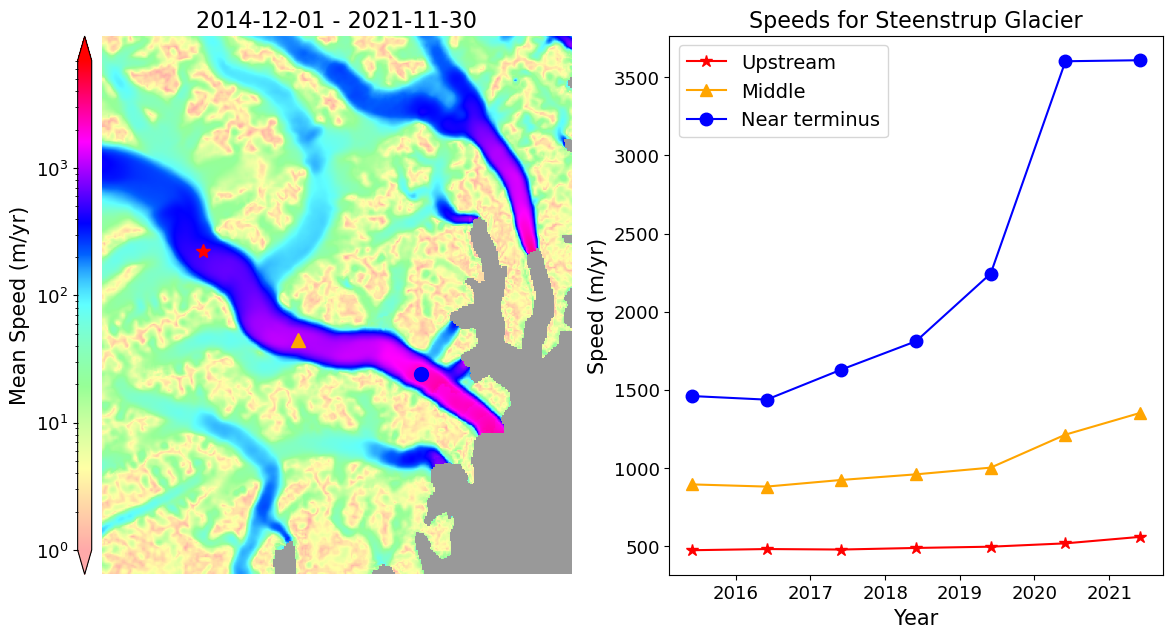

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14,7))
mapAxes, plotAxes = axes
# Map plot
velMean.displayVelForDate(ax=mapAxes, units='km', autoScale=True, axisOff=True, scale='log',
                                 midDate=False, colorBarLabel='Mean Speed (m/yr)', 
                                 extend='both', backgroundColor=(0.6, 0.6, 0.6), colorBarPosition='left', vmin=1, colorBarSize='3%', colorBarPad=.1)
# Loop to plot points
for x, y, symbol, color, label in zip(xpts, ypts, symbols, colors, labels):
    # plot points on map
    mapAxes.plot(x, y, symbol, color=color, markersize=10) 
    # plot values
    myVelReload.plotPoint(x, y, ax=plotAxes, band='vv',  marker=symbol, color=color,  linestyle='-',
                          units='km', label=label, markersize=9)
# Finish plots
myVelReload.labelPointPlot(xLabel='Year', yLabel='Speed (m/yr)', ax=plotAxes, title='Speeds for Steenstrup Glacier')
plotAxes.legend(fontsize=14)

Similar plots for profiles can be produced with `myVelSeries.plotProfile()`. See **Flowlines** and **workingWithGrIMPVelocity** on the GrimpNotebooks repository.

```{admonition} Review
**GrIMP data sets can be large. With these tools we can:**
- The velSeries class can be used to compute statistics for full data stack,
- It can also be used to produce point and profile plots with a lot of control over the plot appearence,
- The imageSeries class not discussed today can do similar things with the SAR mosaic data,
- There are many other notebooks illustrating these functions, which can be reached via links from the central [**GrIMP repository**](https://github.com/fastice/GrIMPTools).
      
```
